 # Day 1: Linear Regression with JAX

 #### **Goal: Derive OLS, implement gradient descent and closed-form solutions in JAX, and visualize optimization paths**

In linear regression we assume that our data can be represented as

\begin{equation}
y(\vec{x},t) = w_o + \sum_{i=1}^{M-1} w_i \phi_i(\vec{x})
\end{equation}

where $\phi(\vec{x})$ are the basis functions that can be gaussian, sigmoid, tanh.

If we suppose we have a dataset $\vec{x}=(x_1,x_2 ...x_n)$ representing $N$ observations and we assume that the observations are i.i.d (independent + identically distributed). The predicted output $y$ can be  defined as a deterministic prediction + a gaussian noise
$$
t = y(\vec{x},t) + N(0,\sigma^2)
$$
where $\epsilon$ is gaussian noise. This implies for a specific $x_i$, the predicted output follows a gaussian distribution with mean $y$ and the gaussian noise std $\sigma^2$
$$
t \sim N(y, \sigma^2)
$$
From this, the likelihood of the observed data t given the inputs, weights and gaussian noise variance is
$$
p(t|\vec{x},\vec{w},\sigma^2) = N(y, \sigma^2)
$$
and the joint PDF 
$$
p(t|\vec{x},\vec{w},\sigma^2) = \prod_i^{N_{\text{samples}}} N(y_i(x_i,w), \sigma^2)
$$
The joint pdf has dimension $D=N_{\text{samples}}$ but the marginal PDF distribution for one specific $x_i$ maps to the gaussian

The joint pdf can be maximized by taking the log of the pdf
$$
p(t|\vec{x},\vec{w},\sigma^2) = \sum_i^{N_{\text{samples}}} \ln{ \frac{1}{\sqrt{2 \pi \sigma^2}} \exp{\frac{-(t_i-y_i)}{2\sigma^2}} }
$$
with some rearrangements
$$
\ln p(t | \vec{x}, \vec{w}, \sigma^2) = -\frac{N_{\text{samples}}}{2} \ln(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{N_{\text{samples}}} (t_i - y_i(x_i, w))^2
$$
Maximizing the likelihood with respect to the gaussian noise $\sigma^2$, it possible to find the $\sigma$ that maximizies the likelihood MLE 
$$
 \sigma_{\text{MLE}}^2 = \frac{1}{N_{\text{samples}}} \sum_i^{N_{\text{samples}}} (t_i-y_i)^2
$$
It is directly observed that to max the likelihood the second term needs to be minimized by the weights, which is the sum of the squared errors
$$
 \vec{w}_{\text{MLE}} =  min \sum_i^{N_{\text{samples}}} (t_i-y_i(x_i, \vec{w}))^2
$$

Note that the optimal std for the added noise is related to the average square diff between predictions and true values. The closer the predictions the smaller the std and viceversa



### Jax implementation of MLE 

We will implement a linear regression using MLE (maximum likelihood estimator) 

In [1]:
import jax
import jax.numpy as jnp
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

# Load Boston Housing dataset from OpenML
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

- **CRIM**: Per capita crime rate by town
- **ZN**: Proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: Proportion of non-retail business acres per town
- **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX**: Nitric oxides concentration (parts per 10 million)
- **RM**: Average number of rooms per dwelling
- **AGE**: Proportion of owner-occupied units built prior to 1940
- **DIS**: Weighted distances to five Boston employment centres
- **RAD**: Index of accessibility to radial highways
- **TAX**: Full-value property-tax rate per $10,000
- **PTRATIO**: Pupil-teacher ratio by town
- **B**: \(1000(B_k - 0.63)^2\) where \(B_k\) is the proportion of blacks by town
- **LSTAT**: % lower status of the population


In [2]:
print(X.describe())
print("\nMissing Values:")
print(X.isnull().sum())

             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    0.385000    3.561000    2.900000   
25%      0.082045    0.000000    5.190000    0.449000    5.885500   45.025000   
50%      0.256510    0.000000    9.690000    0.538000    6.208500   77.500000   
75%      3.677083   12.500000   18.100000    0.624000    6.623500   94.075000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         TAX     PTRATIO           B       LSTAT  
count  506.000000  506.000000  506.000000  506.000000  506.000000  
mean     3.795043  408.237154   18.455534  356.674032   12.653063  
std      2.105710  168.537116    2.164946   91.294864    7.141062 

The covariance is the crossproduct between deviations from the mean of two different variables and the correlation matrix (following Pearsons approach) normalizes it by the two variances
$$
\frac{\sum_i^N (x_i-\overline{x})(y_i-\overline{y})}{\sigma_x^2 \sigma_y^2}
$$
Pearsons can go from -1 to 1, telling us high correlation means more strong correlationship. Negative means when one increases the other decreases from the sign of the covariance, and viceversa.

I have used spearman to be less sensitive to outliers. Spearman uses the same formula but computes ranks based on the distance to the mean an computes the Correlations with the ranks

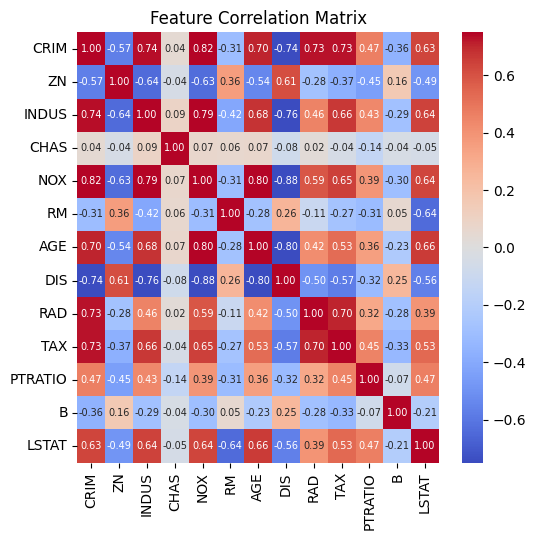

In [3]:
plt.figure(figsize=(5.5, 5.5))
#compute correlation matrix using spearman 
#reduce fontsize of the annotations
sns.heatmap(X.corr(method='spearman'), annot=True, cmap="coolwarm", fmt='.2f', vmin=-0.75, vmax=0.75, annot_kws={"fontsize": 7})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


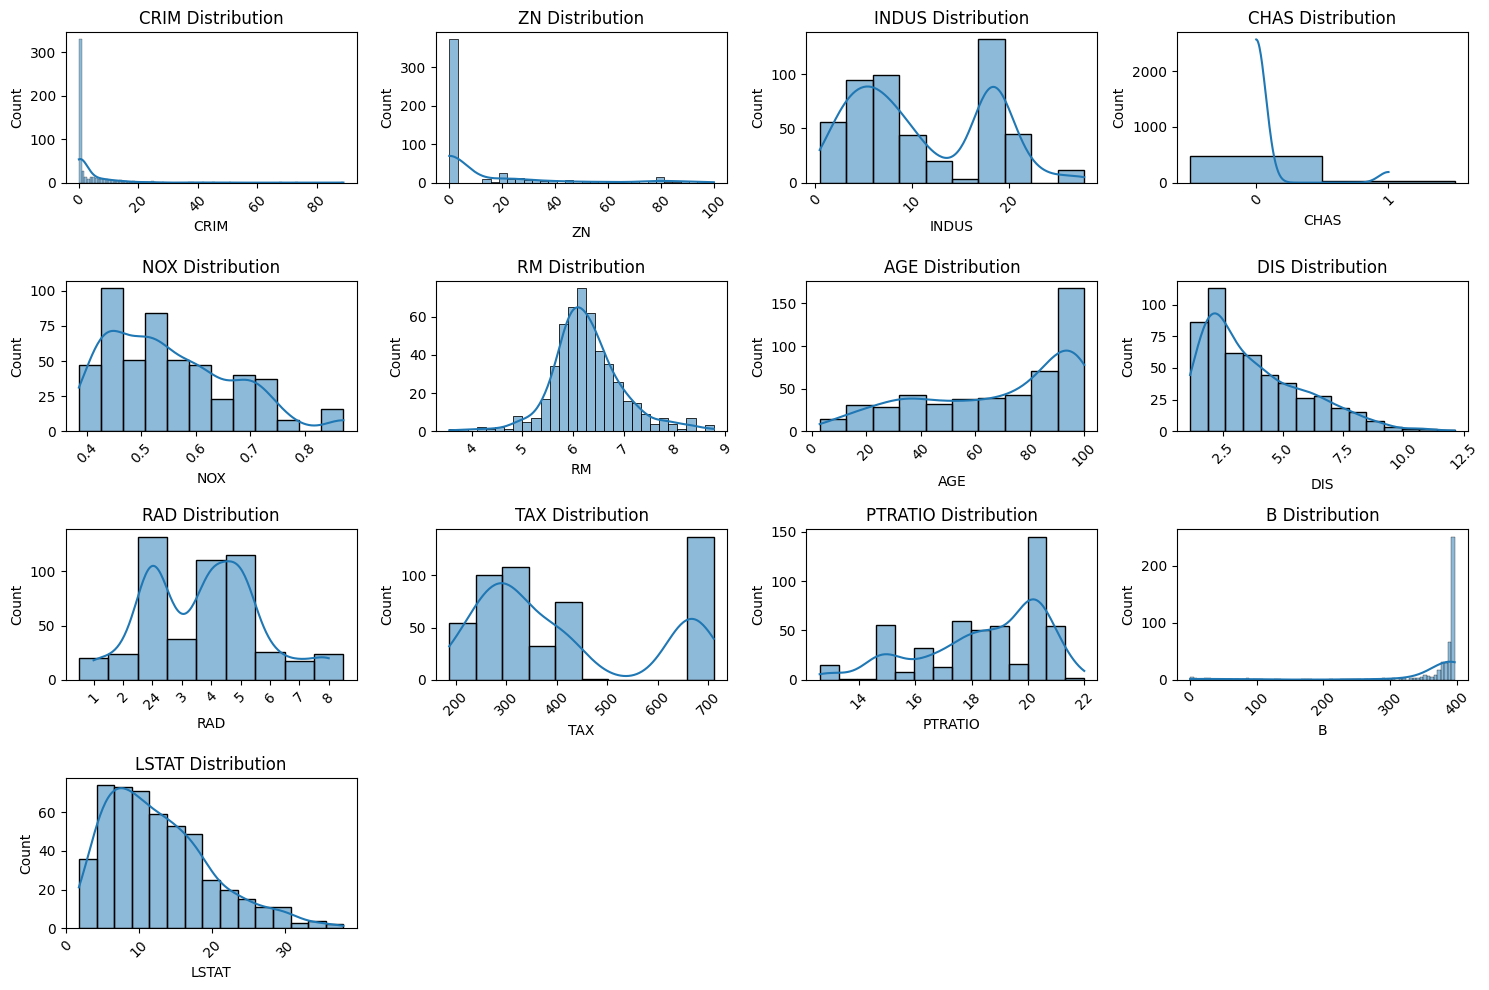

In [4]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(X[column], kde=True)
    plt.title(f'{column} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The output is:

- **MEDV**: % Median value of owner-occupied homes in thousands of dollars

Let's look at correlation + feature insights

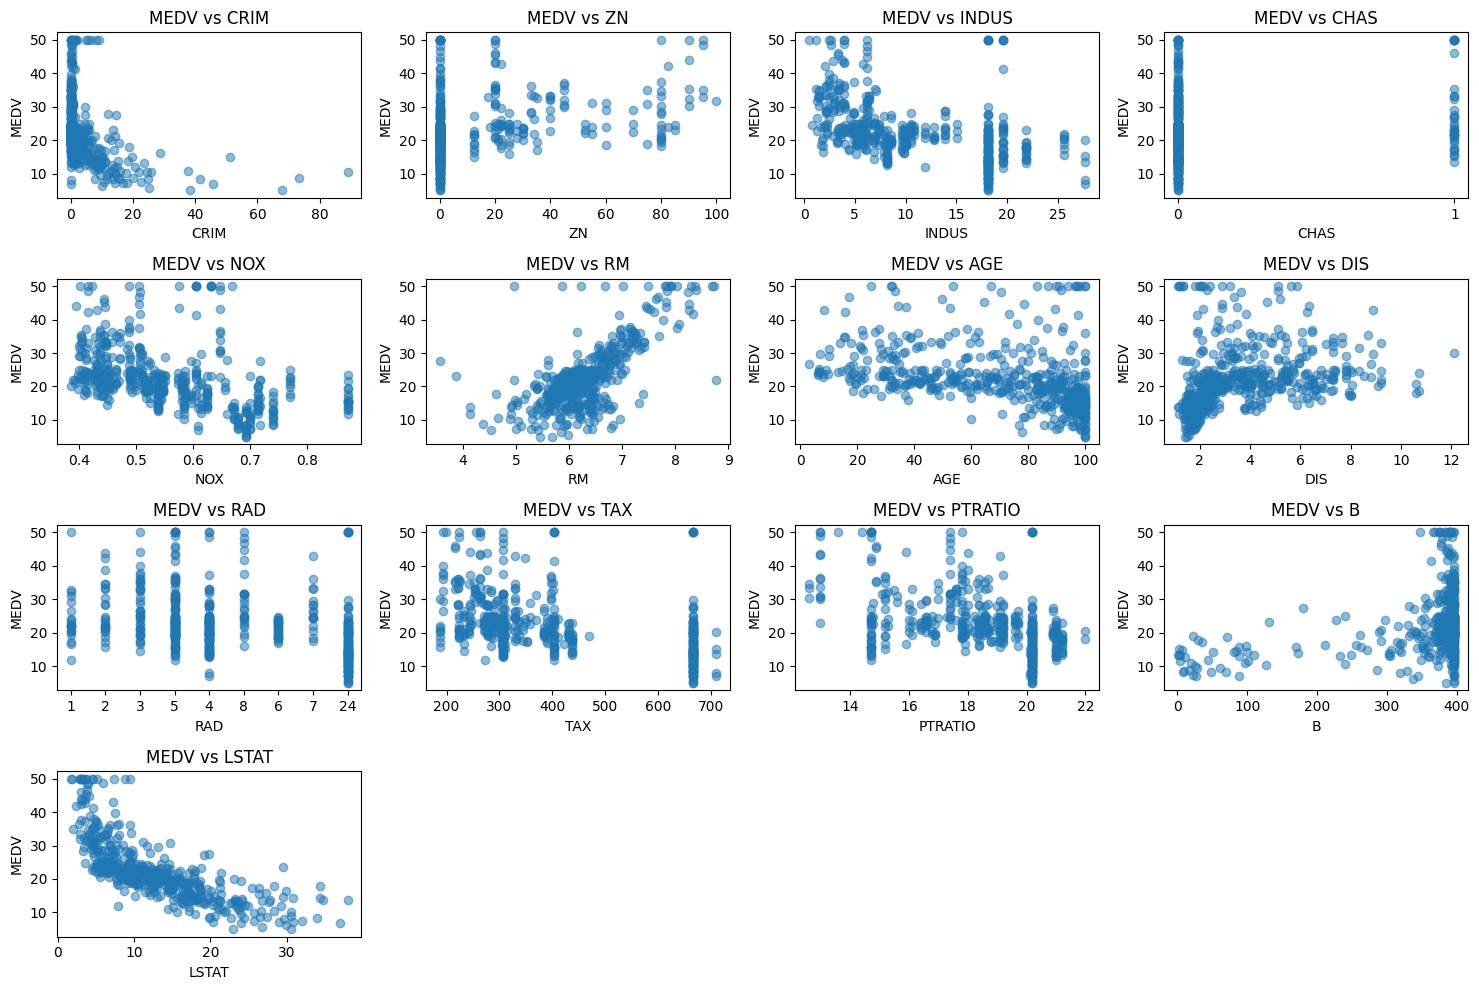

In [5]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(4, 4, i)
    plt.scatter(X[column], y, alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('MEDV')
    plt.title(f'MEDV vs {column}')
plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

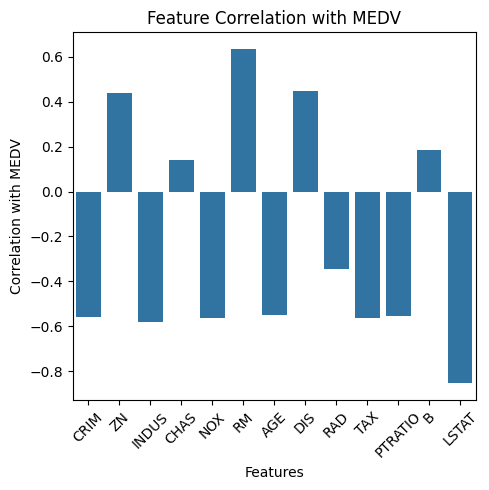

In [6]:
plt.figure(figsize=(8, 8))
import pandas as pd
pandas_y = pd.Series(y)
X_corr_y = X.corrwith(pandas_y,method='spearman')
X_corr_y.sort_values(ascending=False)
#plot X_corr_y
plt.figure(figsize=(5, 5))
sns.barplot(x=X_corr_y.index, y=X_corr_y.values)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Correlation with MEDV')
plt.title('Feature Correlation with MEDV')
plt.tight_layout()
plt.show()

We will now use JAX to basically solve a linear regression problem using MLE estimator. We will use sklearn to preprocess the type of variables and then feed it into the JAX framework

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

categorical_features = ['CHAS']
ordinal_features = ['RAD']
numerical_features = [x for x in X.columns if x not in categorical_features and x not in ordinal_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),        
        ('ord', MinMaxScaler(), ordinal_features)
    ])

X_transformed = preprocessor.fit_transform(X)
variables = preprocessor.get_feature_names_out()

X_numpy = np.array(X_transformed, dtype=np.float32)
y_numpy = np.array(y.to_numpy(), dtype=np.float32)

y_numpy = (y_numpy - y_numpy.mean())/y_numpy.std()

X_train, X_val, y_train, y_val = train_test_split(X_numpy, y_numpy, test_size=0.15, random_state=42)

def compute_jax_arrays(X,y):
    #add bias column to X
    X_jax = jnp.array(X)
    y_jax = jnp.array(y)
    return X_jax, y_jax

X_train_jax, y_train_jax = compute_jax_arrays(X_train, y_train)
X_val_jax, y_val_jax = compute_jax_arrays(X_val, y_val)

print("Jax arrays shapes")
print("Train:", X_train_jax.shape, y_train_jax.shape)
print("Validation:", X_val_jax.shape, y_val_jax.shape)

Jax arrays shapes
Train: (430, 14) (430,)
Validation: (76, 14) (76,)


We now implement the function we want to optimize (loss)
$$
- \ln p(t | \vec{x}, \vec{w}, \sigma^2) = \frac{N_{\text{samples}}}{2} \ln(2\pi\sigma^2) + \frac{1}{2\sigma^2} \sum_{i=1}^{N_{\text{samples}}} (t_i - y_i(x_i, w))^2
$$


In [8]:
from jax import grad, jit


@jit
def compute_loss(params, X, y):
    sigma = params['sigma']
    residuals = y - (jnp.dot(X, params['w']) + params['b'])
    return 0.5*jnp.sum(residuals ** 2)/sigma**2

@jit
def negative_log_likelihood(params, X, y):
    w = params['w']
    b = params['b']
    sigma = params['sigma']
    N_samples = X.shape[0]
    residuals = y - (jnp.dot(X, w) + b)
    likelihood = 0.5*(N_samples * jnp.log(2 * jnp.pi * sigma**2) + jnp.sum(residuals ** 2) / sigma**2)
    average_likelihood = jnp.mean(likelihood)
    return average_likelihood

#automatically derives the function with respect to the first argument
grad_negative_log_likelihood = grad(negative_log_likelihood)

JAX creates some kind of graph that links very basic functions, the grad is computed using backward pass reversing the order on the graph while applying the chain rule of each derivative. I have implemented an Adam optimizer using the first and second moment of the gradients to boost optimization 

In [9]:
import jax.random as random
from tqdm import tqdm

def train(X_train, y_train, X_val, y_val, learning_rate, epochs, n_batches):
    
    w = jnp.zeros(X_train.shape[1])
    b = jnp.array(0.0)
    sigma = jnp.array(0.5)
    
    #dictionary of params
    params = {
        'w': w,
        'b': b,
        'sigma': sigma
    }
    
    momentum = jax.tree_map(jnp.zeros_like, params)
    second_momentum = jax.tree_map(jnp.zeros_like, params)
    
    beta = 0.9
    beta2 = 0.999
    time_step = 1
    #split in batches
    X_train_batches = jnp.array_split(X_train, n_batches)
    y_train_batches = jnp.array_split(y_train, n_batches)
    p_bar = tqdm(range(epochs))
    history = {"train_loss":[], "val_loss":[], "train_mse":[], "val_mse":[]}
    
    
    for i in p_bar:
        val_loss = 0
        train_loss = 0
        val_mse = 0
        train_mse = 0
        for batch in range(n_batches):
            #compute predictions (forward pass)z
            X_batch = X_train_batches[batch]
            y_batch = y_train_batches[batch]            
            
            #loss
            train_loss += negative_log_likelihood(params, X_batch, y_batch)
            
            #backward pass
            grads = grad_negative_log_likelihood(params, X_batch, y_batch)  
            
            momentum = jax.tree_map(lambda past_g, g: past_g * beta + g * (1-beta), momentum, grads)
            second_momentum = jax.tree_map(lambda past_g, g: past_g * beta2 + (g*g) * (1-beta2), second_momentum, grads)
            
            corrected_momentum = jax.tree_map(lambda g: g/jnp.sqrt(1-beta**time_step), momentum)
            corrected_second_momentum = jax.tree_map(lambda g: g/jnp.sqrt(1-beta2**time_step), second_momentum)
            
            params = jax.tree_map(lambda p, g, s: p - learning_rate * g / (jnp.sqrt(s) + 1e-8), params, corrected_momentum, corrected_second_momentum)                                  
            
            #compute validation loss MSE
            val_mse += jnp.mean((y_val - jnp.dot(X_val, params['w']) - params['b'])**2)  
            val_loss += negative_log_likelihood(params, X_val, y_val)
            train_mse += jnp.mean((y_train - jnp.dot(X_train, params['w']) - params['b'])**2)
            time_step += 1
            
        p_bar.set_postfix({"Training Loss": train_loss/n_batches, "Validation Loss": val_loss/n_batches,"Training MSE": train_mse/n_batches,"Validation MSE": val_mse/n_batches})
        p_bar.set_description(f"Epoch {i}")
        history["train_loss"].append(train_loss/n_batches)
        history["val_loss"].append(val_loss/n_batches)
        history["train_mse"].append(train_mse/n_batches)
        history["val_mse"].append(val_mse/n_batches)
        
    return params, history

optimized_params , history= train(X_train_jax, y_train_jax, X_val_jax, y_val_jax, learning_rate=1e-3, epochs=500, n_batches=24)

/var/folders/xs/v6q3rmcj5211sjzbgfbphbfm0000gp/T/ipykernel_24659/2566189144.py:17: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  momentum = jax.tree_map(jnp.zeros_like, params)
Epoch 499: 100%|██████████| 500/500 [00:17<00:00, 28.60it/s, Training Loss=14.000644, Validation Loss=43.398098, Training MSE=0.27854392, Validation MSE=0.16182844] 


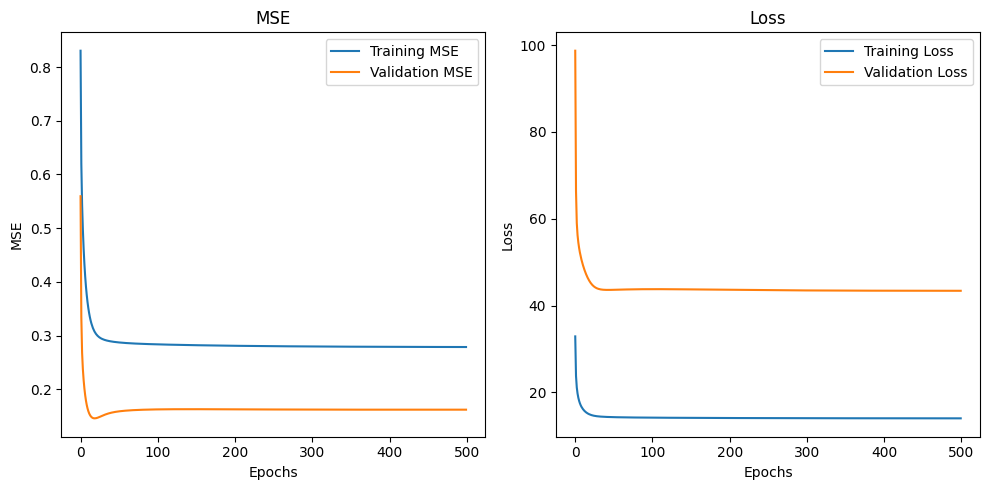

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].plot(history["train_mse"],label="Training MSE")
axes[0].plot(history["val_mse"],label="Validation MSE")
axes[0].legend()
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE')
axes[1].plot(history["train_loss"],label="Training Loss")
axes[1].plot(history["val_loss"],label="Validation Loss")
axes[1].legend()
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
plt.tight_layout()
plt.show()

Even though the metric mean squared error on the val set is lower the validation loss is higher showing some overfitting. This means the model is learning or fitting the training points and is not generalizing towards the val points. Let's check the sigma value in the MLE estimator

### Closed-form solution

From the log likelihood is possible to obtain a solution directly from the derivative $\frac{\partial L}{\partial w}$. Note that assuming Gaussian noise is the same as solving the Least Squares problem

$$
\frac{\partial L}{\partial w} = - \frac{1}{\sigma^2} \sum_{i=1}^{N_{\text{samples}}} 2 (t_i - y_i(x_i, w)) \frac{\partial y_i}{\partial w} = 0
$$

$$
\frac{\partial L}{\partial w} = \sum_{i=1}^{N_{\text{samples}}} 2 (t_i - x_i W)) x_i = 0
$$
Can be rearranged as

$$
X^T (t - X W) = 0 \\
X^T X W = X^T t  \\
$$
where W contains already the bias and X a column of ones. Can be solved using $Ax=b$ inverting $X^T X$

In [11]:
def closed_form_solution(X,y):
    XTX = jnp.matmul(X.T,X)
    XTt = jnp.matmul(X.T,y)
    W = jnp.matmul(jnp.linalg.inv(XTX),XTt)
    return W

(76, 14) (76,)
(76, 15) (15,)


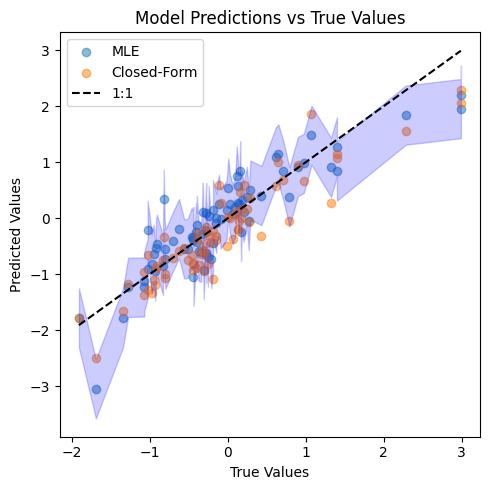

In [12]:
import jax.random as random
#can we plot one y-x axis plot with the model predictions and the true values?

#obtain closed-form solution
print(X_val.shape, y_val.shape)
X_closed_form = np.concatenate([np.ones((X_val.shape[0],1)),X_val],axis=1)
W = closed_form_solution(X_closed_form,y_val)
print(X_closed_form.shape, W.shape)
y_closed_form = jnp.dot(X_closed_form, W)

plt.figure(figsize=(5, 5))
plt.scatter(y_val, jnp.dot(X_val, optimized_params['w']) + optimized_params['b'], alpha=0.5,label="MLE")
plt.scatter(y_val, y_closed_form, alpha=0.5,label="Closed-Form")
sort_index = jnp.argsort(y_val)
y_val_sorted = y_val[sort_index]
X_val_sorted = X_val[sort_index]
sigma = optimized_params["sigma"]
plt.fill_between(y_val_sorted, jnp.dot(X_val_sorted, optimized_params['w']) + optimized_params['b'] - sigma, jnp.dot(X_val_sorted, optimized_params['w']) + optimized_params['b'] + sigma, alpha=0.2,color="blue")
plt.plot(np.linspace(y_val.min(),y_val.max(),100),np.linspace(y_val.min(),y_val.max(),100),color="black",linestyle="--",label="1:1")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs True Values')
plt.legend()
plt.tight_layout()
plt.show()